In [1]:
from glob import glob
import json
from astropy import time
from spacetrack import SpaceTrackClient
import spacetrack.operators as op
import pandas as pd
import os
import numpy as np

from skyfield.api import load, wgs84
from skyfield.api import EarthSatellite
from skyfield.positionlib import position_of_radec
from skyfield.units import Angle
from datetime import timedelta
import pytz
import matplotlib.pyplot as plt

In [2]:
def get_archival_tles(start_date, end_date, norad_ids):
    """
    Collect TLEs for a specific date range.
    Parameters
    ----------
    start_date: Datetime object
        Start date and time of observation.
    end_date: Datetime object
        End date and time of observation.
    Returns
    -------
    file_path: str
        File path to TLE file.
    """
    st = SpaceTrackClient('cfinlay@ska.ac.za', 'SARAORFIsimulator')

    drange = op.inclusive_range(start_date, end_date)

    tles = [x for x in st.tle(norad_cat_id=norad_ids, iter_lines=True, epoch=drange, orderby='TLE_LINE1', format='tle')]
    
    ids = []
    for i in range(int(len(tles)/2)):
        ids.append(int(tles[1::2][i].split()[1]))

    tles = pd.DataFrame(np.array([[tles[::2], tles[1::2]]])[0].T, index=ids)

    tles = tles[~tles.index.duplicated()]
    tles.index.name = 'NORAD_ID'
    tles.columns = ['E1', 'E2']

    return tles

In [3]:
constellation = 'glo'

tle_files = {'gal': 'galileo.latest.tle',
             'gps': 'gps.latest.tle',
             'glo': 'glonass.latest.tle'}

with open(tle_files[constellation], 'r') as f:
    gal_tle = [x.rstrip('\n') for x in f.readlines()]
    
gal_ids =[int(x.split(' ')[1]) for x in gal_tle[2::3]]
gal_names = [x.split(' ')[0] for x in gal_tle[::3]]

In [4]:
files = glob('summaries/1541342249_sdp_l0_scanID_*')
obs_lists = []
for file in files:
    with open(file, 'r') as fp:
        obs_lists.append(json.load(fp))

In [23]:
obs_id = 0

t = time.Time([float(obs_lists[obs_id]['BeginTime']), float(obs_lists[obs_id]['EndTime'])], 
              format='mjd', scale=obs_lists[obs_id]['timeref'].lower())

dt = time.TimeDelta(0, 3, format='jd', scale='local').datetime
t_new = t[0].datetime + np.array([-dt, dt])

df = get_archival_tles(*t_new, gal_ids)

gal_tles = []
for nid, name in zip(gal_ids,gal_names):
    try:
        gal_tles.append(pd.DataFrame(data=[df.T[nid],], index=[nid,]))
    except:
        print(f'{name} {nid} missing. May not have launched yet.')
        pass
gal_df = pd.concat(gal_tles)

print(f'Found {len(df)}/{len(gal_ids)} unique satellite TLEs')
print(f'Maximum NORAD ID found : {gal_df.index.max()}')

COSMOS 44299 missing. May not have launched yet.
COSMOS 44850 missing. May not have launched yet.
COSMOS 45358 missing. May not have launched yet.
COSMOS 46805 missing. May not have launched yet.
COSMOS 52984 missing. May not have launched yet.
Found 21/26 unique satellite TLEs
Maximum NORAD ID found : 43687


In [24]:
scan_ids = [[x for x in obs_lists[obs_id].keys() if 'scan' in x][0] for obs_id in range(len(obs_lists))]

In [25]:
np.where(np.array(scan_ids)=='scan_104')[0]

array([7])

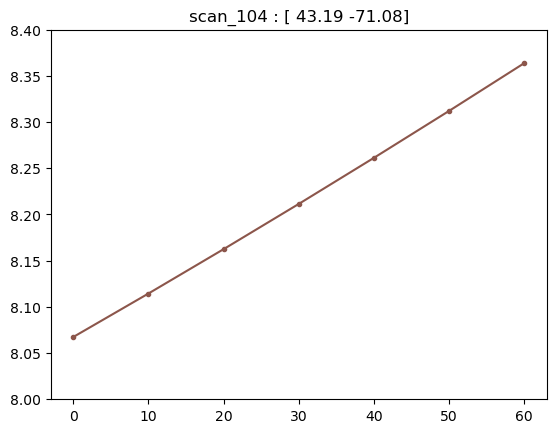

In [30]:
all_obs_ang_sep = []

# for obs_id in range(len(obs_lists)):
for obs_id in np.where(np.array(scan_ids)=='scan_104')[0]:

    field_id = [x for x in obs_lists[obs_id].keys() if 'field_' in x][0]
    scan_id = [x for x in obs_lists[obs_id].keys() if 'scan' in x][0]
    
    t = time.Time([float(obs_lists[obs_id]['BeginTime']), float(obs_lists[obs_id]['EndTime'])], 
                  format='mjd', scale=obs_lists[obs_id]['timeref'].lower())

    dt = time.TimeDelta(0, 2, format='jd', scale='local').datetime
    t_new = t[0].datetime + np.array([-dt, dt])

    ts = load.timescale()

    dt_secs = 10
    times = [t[0].to_datetime(pytz.utc)+i*timedelta(seconds=dt_secs) for i in range(int(np.ceil((t[-1]-t[0]).datetime.seconds/dt_secs)))]
    times = ts.from_datetimes(times)

    meerkat = wgs84.latlon(-33.9322, 18.5105)

    phase_centre = [float(obs_lists[obs_id][field_id]['direction']['m0']['value']),
                    float(obs_lists[obs_id][field_id]['direction']['m1']['value'])]
    target = position_of_radec(Angle(radians=phase_centre[0])._hours, 
                               Angle(radians=phase_centre[1]).degrees,
                               epoch=None, t=None, center=None, target=None)

    satellites = [EarthSatellite(gal_df.iloc[sat_id]['E1'], 
                                gal_df.iloc[sat_id]['E2'], 
                                str(gal_df.index[sat_id]), ts) for sat_id in range(len(gal_df))]

    ang_sep = np.array([(satellite - meerkat).at(times).separation_from(target).degrees for satellite in satellites])

#     print(f'Observation starts {(t[0].to_datetime(pytz.utc)-satellite.epoch.utc_datetime())} away from TLE epoch.')
    
    ang_times = (times.toordinal()-times.toordinal()[0])*24*3600
    all_obs_ang_sep.append(ang_sep)
    if np.min(ang_sep)<100:
        plt.figure()
        plt.title(f'{scan_id} : {np.round(np.rad2deg(phase_centre),2)}')
        plt.plot(ang_times, ang_sep.T, '.-');
        plt.ylim(8, 8.4)

In [31]:
print(f'GLONASS min sep on {scan_id} is {np.min(ang_sep)}')

GLONASS min sep on scan_104 is 8.067399122945671


In [13]:
print(f'GPS min sep on {scan_id} is {np.min(ang_sep)}')

GPS min sep on scan_104 is 32.16043081719109


In [20]:
print(f'Galileo min sep on {scan_id} is {np.min(ang_sep)}')

Galileo min sep on scan_104 is 23.8710650718184


In [19]:
min_ang_sep = [np.min(a_s) for a_s in all_obs_ang_sep]

In [23]:
scan_ids[np.argmin(min_ang_sep)]

'scan_24'

In [10]:
with open('summaries/1541342249_sdp_l0_scanID_104.json', 'r') as fp:

    print(fp.readlines())

['{"BeginTime": "58427.20482169209", "EndTime": "58427.2055621196", "IntegrationTime": "63.97293663024902", "field_1": {"code": "T", "direction": {"m0": {"unit": "rad", "value": "0.7538477010650424"}, "m1": {"unit": "rad", "value": "-1.2405184609800683"}, "refer": "J2000", "type": "direction"}, "name": "J0252-7104"}, "nfields": "1", "numrecords": "15624", "scan_104": {"0": {"BeginTime": "58427.20482169209", "EndTime": "58427.2055621196", "FieldId": "1", "FieldName": "J0252-7104", "IntegrationTime": "7.996616971999901", "SpwIds": "[0]", "StateId": "2", "nRow": "15624", "scanId": "104"}}, "timeref": "UTC"}']
